### Boosting to Uniformity

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
#import uproot
#import ROOT
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# this wrapper makes it possible to train on subset of features
from rep.estimators import SklearnClassifier
from matplotlib import pyplot as plt
from hep_ml.commonutils import train_test_split
from hep_ml import uboost, gradientboosting as ugb, losses
from toy import *

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Welcome to JupyROOT 6.18/00


In [2]:
# Creating data 

var_names = ["M", "labels"]

nb1, ns = int(1E5), int(1E4)
ns_gausfrac = 0.5

bkgnd1_m_raw = random_linear(m=1, n=nb1)


sign1_m_raw  = np.random.normal(loc=0.5, scale=0.01, size = int(ns*ns_gausfrac)).reshape(-1, 1)
sign2_m_raw  = np.random.uniform(size = int(ns*(1-ns_gausfrac))).reshape(-1, 1)


bkgnd1_raw = np.column_stack([bkgnd1_m_raw, np.ones(bkgnd1_m_raw.shape[0])])
bkgnd1_raw = pd.DataFrame(data=bkgnd1_raw,columns=var_names)

sign1_raw = np.column_stack([sign1_m_raw, np.zeros(sign1_m_raw.shape[0])])
sign1_raw = pd.DataFrame(data=sign1_raw,columns=var_names)

sign2_raw = np.column_stack([sign2_m_raw, np.zeros(sign2_m_raw.shape[0])])
sign2_raw = pd.DataFrame(data=sign2_raw,columns=var_names)


data = pd.concat([bkgnd1_raw, sign1_raw, sign2_raw])
data = data.sample(frac=1) #shuffling
    






In [3]:
# Formatting the Dataset
labels = data['labels']
data = data.drop('labels', axis=1)
trainX, testX, trainY, testY = train_test_split(data, np.array(labels.tolist()), random_state=42)
testX_bgnd = testX[testY==1]
#Set training weights so the weight given to signal and background events in total is the same
wtrainY = np.where(trainY==0, (nb1)*1./ns, 1)   

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6f0074e850>,
 Text(0.5,1,u'M'),
 None)

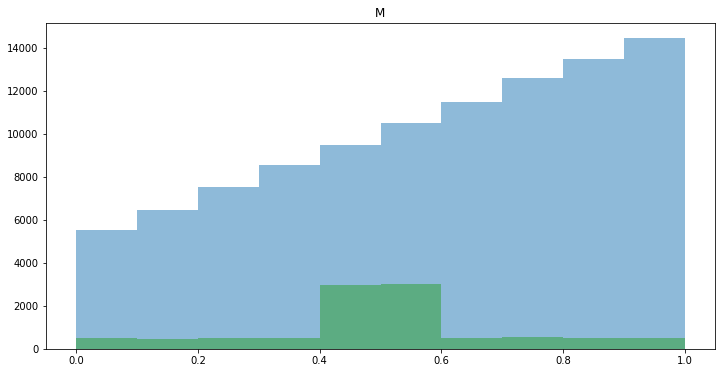

In [4]:
# Displaying the Dataset
def plot_1d(varname="M"):
    plt.hist(data[labels==1][varname], alpha=0.5)
    plt.hist(data[labels==2][varname], alpha=0.5)
    plt.hist(data[labels==0][varname], alpha=0.5)
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1), plt.title("M"),       plot_1d(varname="M")
#plt.subplot(1, 2, 2), plt.title("X"),       plot_1d(varname="X")
 


In [5]:
# Setting up the Training
uniform_features  = ["M"]
train_features = ["M"] #Training on the same feature we are trying to make uniform
n_estimators = 30 #150
base_estimator = DecisionTreeClassifier(max_depth=4)

In [6]:
# Defining Classifiers and Training
from rep.metaml import ClassifiersFactory

classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers['AdaBoost'] = SklearnClassifier(base_ada, features=train_features)


knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
ugbKnn = ugb.UGradientBoostingClassifier(loss=knnloss, max_depth=4, n_estimators=n_estimators,
                                        learning_rate=0.4, train_features=train_features)
classifiers['uGB+knnAda'] = SklearnClassifier(ugbKnn) 

uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     efficiency_steps=12, n_threads=4)
classifiers['uBoost'] = SklearnClassifier(uboost_clf)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)
classifiers['uGB+FL'] = SklearnClassifier(ugbFL)


classifiers.fit(trainX, trainY, parallel_profile='threads-4', sample_weight=wtrainY) #max_iter=10

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


model AdaBoost     was trained in 3.46 seconds
model uGB+knnAda   was trained in 6.69 seconds
model uBoost       was trained in 22.84 seconds
model uGB+FL       was trained in 21.91 seconds
Totally spent 22.84 seconds on training


ClassifiersFactory([('AdaBoost',
                     SklearnClassifier(clf=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                   learning_rate=0.1, loss='deviance', max_depth=4,
                                   max_features=None, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=30,
                                   presort='auto', random_state=None, subsample=1.0, verbose=0,
                                   warm_start=False),
                              features=['M'])),
                    ('uGB+knnAda',
                     SklearnClassifier(clf=UGradientBoostingClassifier(learning_rate=0.4,
                                   loss=KnnAdaLossFunction(knn=10, row_norm=1.0, uniform_features=['M'],
                            

## ROC curves after training

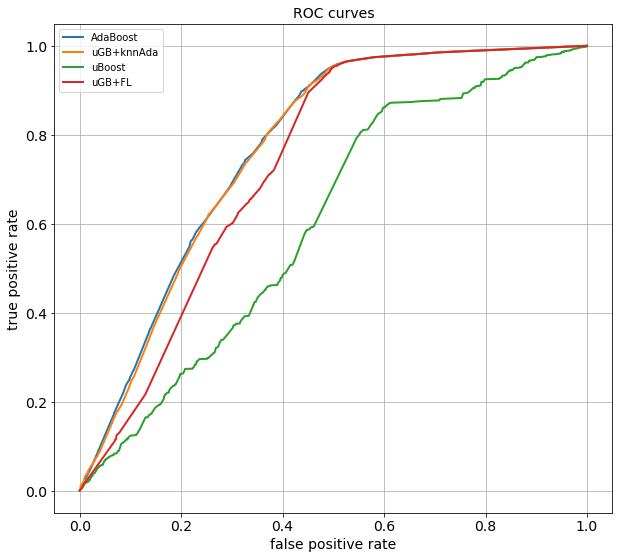

In [7]:
# AUC as a function of number of estimators
from rep.report.metrics import RocAuc
report = classifiers.test_on(testX, testY)

report.roc().plot(new_plot=True, figsize=[10, 9])

## ROC AUC as Function of Number of Estimators
ROC AUC - an area under the ROC curve, the more the better)

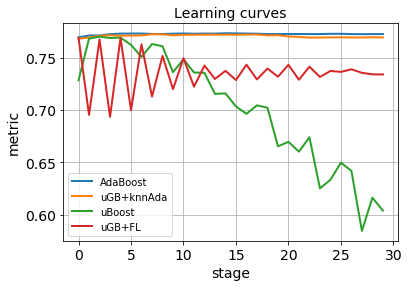

In [8]:
#plt.ylim(0.95, 1.)
#plt.xlim(0., 15.)
report.learning_curve(RocAuc(), steps=1)

## Sculpting a background
Testing whether a peak is sculpted in background

In [9]:
# Getting the predictions of various models
dpredtestY = {}
for clf_name in classifiers:
    dpredtestY[clf_name] = classifiers[clf_name].predict(testX_bgnd)

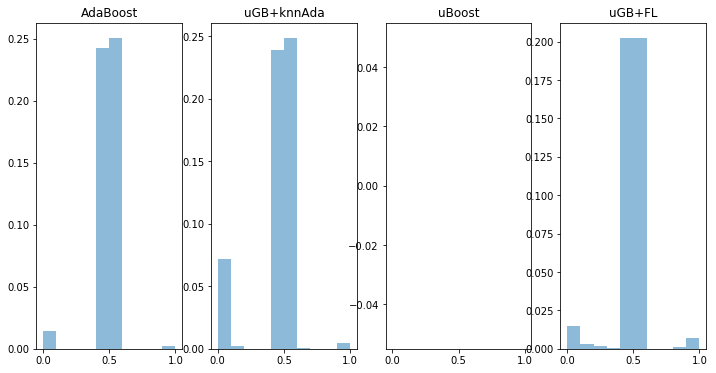

In [10]:
def plot_1d_test(clf_name, varname="M", stype=0):
    contents_tot, bins, patches = plt.hist(testX_bgnd[varname], alpha=0.5)
    contents_sig, _   , _       = plt.hist(testX_bgnd[dpredtestY[clf_name]==stype][varname], alpha=0.5, bins=bins)
    bin_centers =  (bins[1:]+bins[:-1])/2.
    plt.cla()
    plt.hist(bin_centers, weights=contents_sig/contents_tot, bins=bins, alpha=0.5)
    
    plt.title(clf_name)
    #plt.hist(testX[testY==0][varname], alpha=0.5)
    
    
plt.figure(figsize=(12, 6))
for iclf, clf_name in enumerate(classifiers):
    plt.subplot(1, len(classifiers), iclf+1), plt.xlabel("M"), plt.ylabel("Bgnd Frac Acc"),  plot_1d_test(clf_name, varname="M")

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is a metric of nonuniformity &mdash; less is better. 

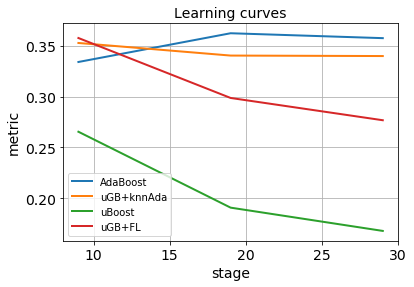

In [11]:
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM
report.learning_curve(BinBasedSDE(uniform_features, uniform_label=1))

## CvM learning curve
CvM is a metric of non-uniformity based on Cramer-von Mises distance. We are using knn (based on neighbours) version here.

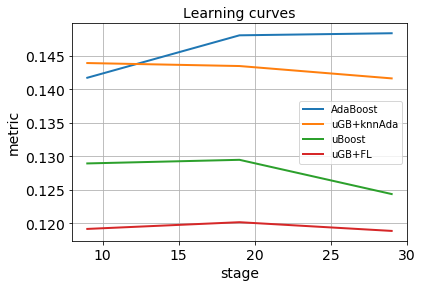

In [12]:
report.learning_curve(KnnBasedCvM(uniform_features, uniform_label=1))